# **PDS Projekt**


**Autor: Vojtěch Fiala \<xfiala61\>**

Než se může začít ddělat cokoliv dalšího, jsou nejprve načtena data (poskytnutý Parquet) a importovány knihovny 

In [194]:
import pandas
import matplotlib.pyplot as plt
import numpy
import seaborn



INPUT_FILE_PATH = "./tls-pds-07-03-2024.parquet"

df = pandas.read_parquet(INPUT_FILE_PATH)

Názvy sloupců obsahují i datový typ, který odstraním, ať se s dataframem lépe pracuje.

In [227]:
# Odstraneni datovych typu z nazvu sloupcu (nebudu je potrebovat)
for col in df.columns.tolist():
    col_names = col.split()
    if len(col_names) > 1:
        df = df.rename(columns={col:col_names[1]})

print(df.columns.tolist())
print("Celkovy pocet vsech zaznamu:", df.shape[0])

['TLS_SNI', 'TIME_FIRST', 'TIME_LAST', 'PACKETS', 'PACKETS_REV', 'BYTES', 'BYTES_REV', 'TCP_FLAGS', 'PPI_PKT_DIRECTIONS', 'PPI_PKT_TIMES', 'PPI_PKT_LENGTHS', 'PPI_PKT_FLAGS']
Celkovy pocet vsech zaznamu: 1287422


Dataset jako takový obsahuje 1 287 422 řádků/toků. Popis informací obsažených v jednotlivých řádcích je v [zadání](https://moodle.vut.cz/pluginfile.php/843353/mod_page/content/10/PDS_analyza_podobnosti_sluzeb_07_03_2024.pdf). Detailnější informace jsou, jak zadání zmiňuje, na stránkách [ipfixprobe](https://github.com/CESNET/ipfixprobe).

## TLS_SNI

Nejprve se zaměřím na sloupec TLS_SNI, který určuje název serveru z pohledu klienta. Pro začátek si zjistím počty unikátních názvů. Dále pak množství adres, se kterými bylo navázáno spojení aspoň 3x (zvoleno jako ddostatečně vysoká hodnota na základě toho, že většina toků je s adresami, které se vyskytují pouze 1-2x).

Pocet unikatnich nazvu: 19910
Pocet vyskytu hodnoty: TLS_SNI
www.google.com                                                       75182
dns.google                                                           31026
doh.opendns.com                                                      28923
fonts.gstatic.com                                                    28832
play.googleapis.com                                                  23845
                                                                     ...  
12280df69cc365e35c9caf819967d8fe.safeframe.googlesyndication.com         1
img.adpartner.pro                                                        1
api.chilipiper.com                                                       1
c64b5e710ecb7e71d241af7a21e10290.safeframe.googlesyndication.com         1
p4-hqoeyco3c7m5q-vxz3de65eqcara6s-if-v6exp3-v4.metric.gstatic.com        1
Name: count, Length: 19910, dtype: int64


Text(0.5, 1.0, 'Počet unikátních adres TLS_SNI vyskytujících se aspoň 3x v poměru ke všem unikátním adresám')

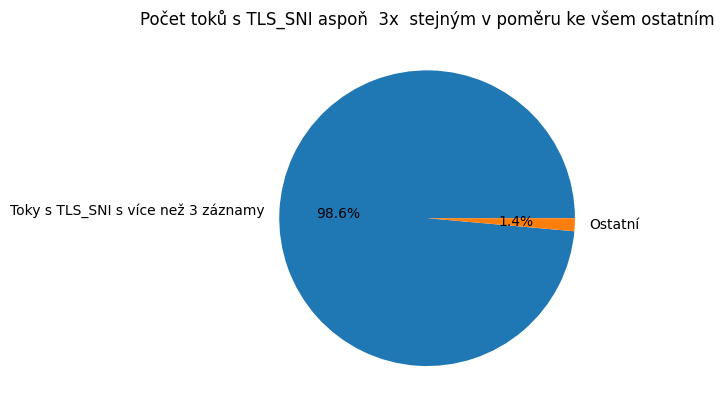

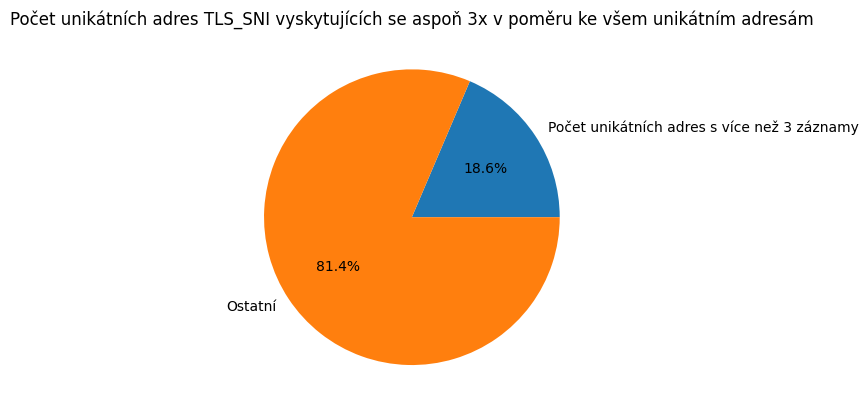

In [228]:
print("Pocet unikatnich nazvu:", df["TLS_SNI"].nunique())
print("Pocet vyskytu hodnoty:" , df["TLS_SNI"].value_counts())
# Nejpouzivanejsi hodnoty TLS_SNI - zakomentovano at nespamuje vystup
#print(df["TLS_SNI"].value_counts().head(300).to_string())

# Konstanta
cutoff_occurences = 3
val_counts = df["TLS_SNI"].value_counts()

# Vyfiltruj pocet vyskytu tam, kde je >= zvolenemu poctu
val_counts = val_counts[val_counts >= cutoff_occurences]

# Podle indexu vyfiltrovanych radku vyber jenom je (tzn. jejich indexy) - Vsechny adresy
n_of_occurs = df[df["TLS_SNI"].isin(val_counts.index)]["TLS_SNI"].value_counts().sum(numeric_only=True)
less_than_cutoff = df.shape[0] - n_of_occurs

fig, ax = plt.subplots()

# Pocet toku k adresam TLS_SNI, ktere maji aspon 30 zaznamu v pomeru ke vsem ostatnim
ax.pie([n_of_occurs, less_than_cutoff], labels=["Toky s TLS_SNI s více než " + str(cutoff_occurences) + " záznamy", "Ostatní"], autopct='%1.1f%%');
ax.set_title("Počet toků s TLS_SNI aspoň  " + str(cutoff_occurences) + "x  stejným v poměru ke všem ostatním")

# Unikatni adresy
n_of_occurs_unique_over_30 = df[df["TLS_SNI"].isin(val_counts.index)]["TLS_SNI"].nunique()
n_of_uniques = df["TLS_SNI"].nunique()
fig, ax = plt.subplots()

n_of_occurs_unique_under_30 = n_of_uniques - n_of_occurs_unique_over_30

# Pocet toku k adresam TLS_SNI, ktere maji aspon 30 zaznamu v pomeru ke vsem unikatnim adresam
ax.pie([n_of_occurs_unique_over_30, n_of_uniques], labels=["Počet unikátních adres s více než " + str(cutoff_occurences) + " záznamy", "Ostatní"], autopct='%1.1f%%');
ax.set_title("Počet unikátních adres TLS_SNI vyskytujících se aspoň " + str(cutoff_occurences) + "x v poměru ke všem unikátním adresám")


81.4% všech unkátních adres serveru (tzn. sloupec TLS_SNI) se vyskytlo pouze 1-2x. V kontextu všech záznamů se ale jedná o pouhých 1.4%. 

Z výsledku je patrné, že se v datasetu nachází 19 910 unikátních adres serverů. Je ale taky vidět, že spousta z nich se vyskytla jen jednou. Jelikož se chci nejprve zaměřit na TLS_SNI, tyto hodnoty by zkreslovaly statistiky, takže je odstraním. Mazat budu nejnižších 81.4% hodnot, což ačkoliv vypadá děsivě, znamená pouze 1,4% všech záznamů -  adresy, se kterými jsou evidovány pouze 1-2 toky.

Je zajímavé, že 1.4 % všech záznamů obsahuje 81.4 % unikátních adres serverů. To znamená, že ve velké většině případů (98.6%) se spojení vytvářela se servery opakovaně (tzn. aspoň 3x) - uživatelé, jejichž toky byly měřeny, se pravděpodobně pohybují na již znamých stránkách a nové stránky tvoří jen malé procento navštívených.

Je ale nutné zmínit, že mnoho z nejčastějších adres pravdděpodobně nejsou stránky, které by uživatel navštěvoval vědomě, ale automaticky v rámci fungování aplikací (dns.google, doh.opendns.com, font.gstatic.com, play.googleapis.com....)

Stránkou, se kterou se spojení ustanovuje nejčastěji ze všech je www.google.com. Vzhledem k tomu, že se mezi adresami s vysokým počtem výskytů objevuje i google.cz a google.sk (a také google.cn) utvrzuje dominantní postavení google vyhledávače. Další zajímavost je, že v TOP 5 výsledcích souvisí 2 z nich s DNS -- to by mohlo znamenat, že uživatelé sítě aktivně používají [DNS over HTTPS](https://en.wikipedia.org/wiki/DNS_over_HTTPS)


In [233]:
cutoff_occurences = df["TLS_SNI"].value_counts().quantile(0.814)

val_counts = df["TLS_SNI"].value_counts()

# Vyfiltruj pocet vyskytu tam, kde je >= zvolenemu poctu
val_counts = val_counts[val_counts >= cutoff_occurences]

# Podle indexu vyfiltrovanych radku vyber jenom je (tzn. jejich indexy)
filtered_df_tls_sni = df[df["TLS_SNI"].isin(val_counts.index)]

# Pocet odebranych hodnot = pocet_puvodnich - pocet_novych
values_removed = df.shape[0] - filtered_df_tls_sni.shape[0]

# Pocet smazanych unikatnich adres serveru, ktere se vsak vyskytly jen 1-2x
how_many_servers_removed = df["TLS_SNI"].nunique() - filtered_df_tls_sni["TLS_SNI"].nunique()

print("Odstraneno hodnot:", values_removed, "coz je v procentech:", values_removed/df.shape[0] * 100, "% vsech zaznamu")
print("Procento zaznamu (radku), ktere maji pouze 1-2 pripojeni na server v celem datasetu:",\
      how_many_servers_removed / df["TLS_SNI"].nunique() * 100)
# Overeni ze hodnot je mene
print("Pocet unikatnich nazvu:", filtered_df_tls_sni["TLS_SNI"].nunique())


print("\nZajimavost - Frekvence vyskytu pornografickych webu:\n\n")
# Zajimavost - kolik je v datasetu navstivenych 18+ webu? Pri prohlizeni dat jsem na jeden nahodou narazil... kolik jich je celkem?
# https://www.semrush.com/trending-websites/global/adult - weby jako patreon nebo deviantart nejsou vyhradne nsfw, takze je nezahrnuju
# Seznam nize obsahuje vybrane stranky z https://www.semrush.com/trending-websites/global/adult a nejcastejsi nazvy podobnych stranek
top_10_most_visited_p_sites_regex = '|'.join(["xvideos.com", "xnxx.com", "xhamster.com", "onlyfans.com", 
"redtube.com", "thisvid.com", "redgifs.com", "porn", "hentai"])

# Vypis vsech vysledku
print(df[df["TLS_SNI"].str.contains(top_10_most_visited_p_sites_regex)]["TLS_SNI"].value_counts().to_string())

# Jeden z nich - podporneopatrenia.minedu.sk - nevypada jako hledana stranka - odstranim jeji vysledky (-3)
p_results = df[df["TLS_SNI"].str.contains(top_10_most_visited_p_sites_regex)]["TLS_SNI"].value_counts().sum(numeric_only=True) - 3
print("Pornografickych webu:", p_results, ".\nTyto weby tvori pouze minimalne", p_results / df.shape[0] * 100 ,"% vsech vysledku")

Odstraneno hodnot: 18161 coz je v procentech: 1.410648567447193 % vsech zaznamu
Procento zaznamu (radku), ktere maji pouze 1-2 pripojeni na server v celem datasetu: 77.17227523857359
Pocet unikatnich nazvu: 4545

Zajimavost - Frekvence vyskytu pornografickych webu:


TLS_SNI
www.pornuj.cz                             10
jenporno-cz.webpkgcache.com                3
podporneopatrenia.minedu.sk                2
hentaihaven-xxx.webpkgcache.com            2
pornjack.net                               1
www.lifeisporno.com                        1
amp-xhamster-com.cdn.ampproject.org        1
thepornguy-org.webpkgcache.com             1
cz-amp-xhamster-com.cdn.ampproject.org     1
media.porndudecdn.com                      1
Pornografickych webu: 20 .
Tyto weby tvori pouze minimalne 0.0015534921727296878 % vsech vysledku


Je patrné, že hodnoty byly odstraněny. Z původních 19 910 adres jich zůstalo pouze 4545, které mají alespoň 3 záznamy.

Při úvodním prohlížení datasetu jsem také narazil na stránku s pornografickým obsahem. Jelikož při běžném provozu bylo dle [článku](https://www.statista.com/chart/16959/share-of-the-internet-that-is-porn/) v letech 2005-2014 tohoto typu provozu něco mezi 13-20%, očekával jsem obdobné hodnoty, nicméně dataset takových webů obsahuje pouze 0.0015 %. To může znamenat, že se pravděpodobně nejedná o data z "domácí" sítě, ale spíše z nějaké pracovní sítě a tyto stránky jsou navštěvovány pouze za vznešenými účely.
 
Dále si zjistím základní informace o sloupci TLS_SNI, jako je průměrný počet toků k jednomu serveru:

In [234]:
filtered_df_tls_sni["TLS_SNI"].value_counts().describe()

count     4545.000000
mean       279.265347
std       1995.394699
min          3.000000
25%          4.000000
50%          9.000000
75%         34.000000
max      75182.000000
Name: count, dtype: float64

Průměrný počet toků k jednomu serveru ke 279. Nejvíce jich bylo 75182. Minimální počet spojení (3) nemá cenu brát v potaz.

Jelikož je v TOP nejvyskytovanejších hodnotách často k vidění něco souvsející s googlem, zjistím, kolik procent trafficu souvisí s googlem:

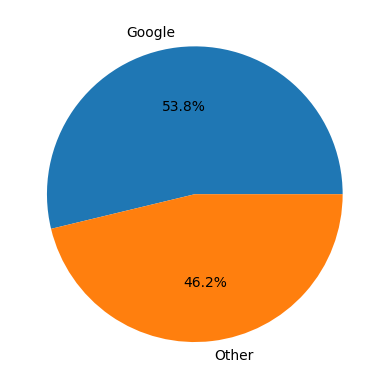

In [186]:
# Budu hledat substring "google" v cele adrese
googles = filtered_df_tls_sni[filtered_df_tls_sni["TLS_SNI"].str.contains("google")]["TLS_SNI"].value_counts().sum(numeric_only=True)

# Pocet vsech ostatnich:
other_pages = filtered_df_tls_sni["TLS_SNI"].value_counts().sum(numeric_only=True) - googles

fig, ax = plt.subplots()
ax.pie([googles, other_pages], labels=["Google", "Ostatní"], autopct='%1.1f%%');


Výsledky, které obsahují v TLS_SNI, tedy adrese serveru, substring "google", tedy služby z velké části nejspíše poskytované právě Googlem, tvoří nadpoloviční většinu všech toků. Součásti jsou sice i služby, které běží pravděpodobně někde na pozadí, ale i tak to považuji za velmi vysoké číslo. 

Jelikož je toto číslo tak vysoké, je možné, že data pochází od uživatelů používajících pravděpodobně Google Chrome nebo přímo ChromeOS. Toto jsou ovšem pouze spekulace, co je jisté tak je, že služby googlu tvoří nadpoloviční většinu veškerého HTTPS trafficu.